## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [11]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import sys
sys.path.append('waveglow/')
import numpy as np
import torch

import importlib.util

from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
#from denoiser import Denoiser

In [12]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [26]:
checkpoint_dir = 'normtest/'
checkpoint_name = 'checkpoint_1000'

In [27]:
spec = importlib.util.spec_from_file_location("hparams.create_hparams", os.path.join(checkpoint_dir, 'hparams.py'))
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)

hparams = foo.create_hparams()
hparams.sampling_rate = 16000

In [28]:
noise_dim = hparams.noise_dim

In [29]:
hparams

HParams([('add_gan_noise', True), ('attention_dim', 128), ('attention_location_kernel_size', 31), ('attention_location_n_filters', 32), ('attention_rnn_dim', 1024), ('batch_size', 16), ('cudnn_benchmark', True), ('cudnn_enabled', True), ('decoder_rnn_dim', 1024), ('discrim_min_width', 64), ('discrim_norm_type', 'batch'), ('discrim_steps', 1), ('discrim_stride', 16), ('dist_backend', 'nccl'), ('dist_url', 'tcp://localhost:54321'), ('distributed_run', False), ('dynamic_loss_scaling', True), ('encoder_embedding_dim', 512), ('encoder_kernel_size', 5), ('encoder_n_convolutions', 3), ('epochs', 500), ('filter_length', 1024), ('fp16_run', False), ('gate_threshold', 0.5), ('gen_steps', 2), ('grad_clip_thresh', 1.0), ('hop_length', 128), ('ignore_layers', ['embedding.weight']), ('iters_per_checkpoint', 1000), ('iters_per_train_log', 50), ('label_flip_prob', 0.05), ('label_smooth', 0.2), ('learning_rate', 0.0001), ('load_mel_from_disk', False), ('mask_padding', True), ('max_decoder_steps', 1000)

#### Load model from checkpoint

In [30]:
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
model = load_model(hparams)
print(torch.load(checkpoint_path).keys())
#model.load_state_dict(torch.load(checkpoint_path))
model.load_state_dict(torch.load(checkpoint_path)['gen_dict'])
_ = model.cuda().eval()

dict_keys(['iteration', 'gen_dict', 'discrim_dict', 'g_optimizer', 'd_optimizer', 'learning_rate'])


#### Load WaveGlow for mel2audio synthesis and denoiser

In [22]:
waveglow_path = 'pretrained/waveglow_256channels_ljs_v2.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()

/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the 

#### Prepare text input

In [31]:
text = "zero"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
print(sequence.shape)

torch.Size([1, 4])


### Randomly sample

Warning! Reached max decoder steps
Warning! Reached max decoder steps
Warning! Reached max decoder steps


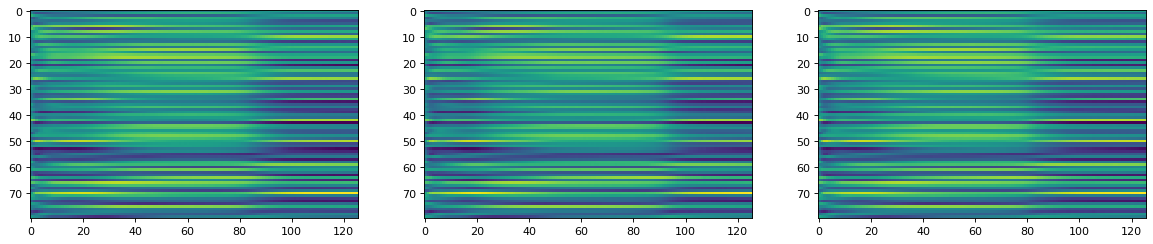

In [32]:
plt.figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
maxlen = 126
for i in range(3):
    sample = np.random.normal(size = (1, sequence.shape[1], noise_dim))
    sample = torch.autograd.Variable(
        torch.from_numpy(sample)).cuda().float()
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, sample)
    plt.subplot(1, 3, i+1)
    plt.imshow(mel_outputs_postnet.detach().float().cpu().numpy()[0, :, 0:maxlen])

#### Decode text input and plot results

In [10]:
maxlen = 126
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, sample)
print(mel_outputs_postnet.shape)
plot_data((mel_outputs.float().data.cpu().numpy()[0, :, 0:maxlen],
           mel_outputs_postnet.float().data.cpu().numpy()[0, :, 0:maxlen],
           alignments.float().data.cpu().numpy()[0].T))

Warning! Reached max decoder steps
torch.Size([1, 80, 1000])


In [25]:
plt.imshow(mel_outputs_postnet.float().data.cpu().numpy()[0, :, 0:maxlen],)

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

#### Synthesize audio from spectrogram using WaveGlow

In [27]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/michael/miniconda3

/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/michael/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/michael/miniconda3

#### (Optional) Remove WaveGlow bias

In [47]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

NameError: name 'denoiser' is not defined